# Fase 2 - Proyecto Machine Learning

In [426]:
#Funciones y librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import heapq

#Paso 1
def asignacion_tamanos(n_prods):
    tam = ['pequeño','mediano','grande']
    pesos = [.55, .35, .1]
    datos = random.choices(tam, weights = pesos, k=n_prods)
    return datos

#Paso 2.1
def ajustar_dimensiones(dimension, categoria):
    if categoria == 'pequeño':
        return np.clip(dimension, 5, 30)
    if categoria == 'mediano':
        return np.clip(dimension, 30.1, 50)
    if categoria == 'grande':
        return np.clip(dimension, 50.1, 100)

def generar_dimensiones(categoria):
    #Info paquetes pequeños - dim alta
    mu_p_alto, sigma_p_alto = 12.5, 1.48
    mu_p_ancho, sigma_p_ancho = 15, 2.9
    mu_p_largo, sigma_p_largo = 17.5, 1.48
    #Info paquetes medianos - dim alta
    mu_m_alto, sigma_m_alto = 37.5, 1.48
    mu_m_ancho, sigma_m_ancho = 35, 2.93
    mu_m_largo, sigma_m_largo = 40, 5.81
    #Info paquetes grandes - dim alta
    mu_g_alto, sigma_g_alto = 75, 14.47
    mu_g_ancho, sigma_g_ancho = 60, 5.81
    mu_g_largo, sigma_g_largo = 70, 5.81
    if categoria == 'pequeño':
        #Dimensiones con distribucion normal de paquetes PEQUEÑOS
        altos = np.random.normal(mu_p_alto, sigma_p_alto)
        anchos = np.random.normal(mu_p_ancho, sigma_p_ancho)
        largos = np.random.normal(mu_p_largo, sigma_p_largo)
    if categoria == 'mediano':
        #Dimensiones con distribucion normal de paquetes MEDIANOS
        altos = np.random.normal(mu_m_alto, sigma_m_alto)
        anchos = np.random.normal(mu_m_ancho, sigma_m_ancho)
        largos = np.random.normal(mu_m_largo, sigma_m_largo)
    if categoria == 'grande':
        #Dimensiones con distribucion normal de paquetes GRANDES
        altos = np.random.normal(mu_g_alto, sigma_g_alto)
        anchos = np.random.normal(mu_g_ancho, sigma_g_ancho)
        largos = np.random.normal(mu_g_largo, sigma_g_largo)
    alto = ajustar_dimensiones(altos,categoria)
    ancho = ajustar_dimensiones(anchos,categoria)
    largo = ajustar_dimensiones(largos,categoria)
    return altos, ancho, largo

#Paso 2 - Generar dimensiones
def paso_dimensiones(categorias_asig):
    data = []
    for i, categoria in enumerate(categorias_asig):
        alto, ancho, largo = generar_dimensiones(categoria)
        data.append([i+1, categoria, round(alto, 2), round(ancho, 2), round(largo, 2)])
    df = pd.DataFrame(data, columns = ['ID_PAQUETE', 'CATEGORIA_ASIGNADA','ALTO','ANCHO','LARGO'])
    return df

#Paso 3.1 - Asignar pesos
def ajustar_peso(peso, categoria):
    if categoria == 'pequeño':
        return np.clip(peso,.1,10)
    if categoria == 'mediano':
        return np.clip(peso,10.1,30)
    if categoria == 'grande':
        return np.clip(peso,30.1,100,)

#Paso 3 - Generar pesos
def asignacion_pesos(datos_2):
    mu_p_peso = 4.9
    sigma_p_peso = 2.85
    mu_m_peso = 19.9
    sigma_m_peso = 5.77
    mu_g_peso = 65
    sigma_g_peso = 20.17
    pesos = []
    for i in range(len(datos_2)):
        if datos_2['CATEGORIA_ASIGNADA'][i] == 'pequeño':
            peso = np.random.normal(mu_p_peso, sigma_p_peso)
        if datos_2['CATEGORIA_ASIGNADA'][i] == 'mediano':
            peso = np.random.normal(mu_m_peso, sigma_m_peso)
        if datos_2['CATEGORIA_ASIGNADA'][i] == 'grande':
            peso = np.random.normal(mu_g_peso, sigma_g_peso)
        peso = ajustar_peso(peso, datos_2['CATEGORIA_ASIGNADA'][i])
        pesos.append(peso)
    datos_2['PESO_ASIGNADO'] = pesos
    return datos_2

#Paso 4 - Tipo de manipulacion
def asignacion_manipulacion(n_prods, datos_2):
    tam = ['fragil', 'normal']
    pesos = [.4, .6]
    tipos = random.choices(tam, weights = pesos, k = n_prods)
    datos_2['TIPO_MANIPULACION'] = tipos
    return datos_2

#Paso 5 - Lugar de procedencia
def asignacion_procedencia(n_prods, datos_2):
    tam = ['A', 'B', 'C', 'D']
    pesos = [.25,.25,.25,.25]
    tipos = random.choices(tam, weights = pesos, k = n_prods)
    datos_2['LUGAR_PROCEDENCIA'] = tipos
    return datos_2

#Paso 6 - Lugar de procedencia
def asignacion_temperatura(n_prods, datos_2):
    tam = ['ambiente','refrigerado']
    pesos = [.53,.47]
    tipos = random.choices(tam, weights = pesos, k = n_prods)
    datos_2['TEMPERATURA_ALMACENAMIENTO'] = tipos
    return datos_2

#Paso 7 - Protocolo
def asignacion_protocolo(n_prods, datos_2):
    tam = ['Protocolo_1','Protocolo_2']
    pesos = [.62,.38]
    tipos = random.choices(tam, weights = pesos, k = n_prods)
    datos_2['PROTOCOLO'] = tipos
    return datos_2
#WoE 
def woe_procedencia(df):
    #Paso 1: Calcular woe para la variable LUGAR_PROCEDENCIA
    #1. dividir las muestras por protocolos
    protocolo_1 = df[df['PROTOCOLO']=='Protocolo_1']
    protocolo_2 = df[df['PROTOCOLO']=='Protocolo_2']
    #2. Contar las frecuencias de cada categoria de eventos
    freq_protocolo1 = protocolo_1['LUGAR_PROCEDENCIA'].value_counts()
    freq_protocolo2 = protocolo_2['LUGAR_PROCEDENCIA'].value_counts()
    #3. Calcular probabilidades de protocolo 1 y protocolo2 para cada categoria
    prob_prot1 = freq_protocolo1 / len(protocolo_1)
    prob_prot2 = freq_protocolo2 / len(protocolo_2)
    #4. Calcular el WoE para cada categoria
    woe_dict = {}
    for categoria in freq_protocolo1.index.union(freq_protocolo2.index):
        p_protocolo1 = prob_prot1.get(categoria, 0)
        p_protocolo2 = prob_prot2.get(categoria, 0)
        if p_protocolo1 > 0 and p_protocolo2 > 0:
            woe = np.log(p_protocolo1/p_protocolo2)
        else:
            woe = 0
        woe_dict[categoria] = woe
    df['LUGAR_PROCEDENCIA_WOE'] = df['LUGAR_PROCEDENCIA'].map(woe_dict)
    return df

# Funcion heuristica
def heuristica(a, b):
    # Usamos la distancia de Manhattan para estimar el costo de llegar al objetivo
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Funcion a *
def a_star(inicio, objetivo, mapa_planta):
    # La cola de prioridad (min-heap) para el algoritmo A*
    open_list = []
    heapq.heappush(open_list, (0 + heuristica(inicio, objetivo), 0, inicio))  # (f, g, (x, y))
    
    # Diccionario para mantener el camino más corto encontrado
    came_from = {}
    
    # Distancia mínima hasta cada nodo
    g_score = {inicio: 0}
    
    while open_list:
        _, current_g, current_node = heapq.heappop(open_list)
        
        # Si llegamos al objetivo, reconstruimos el camino
        if current_node == objetivo:
            path = []
            while current_node in came_from:
                path.append(current_node)
                current_node = came_from[current_node]
            path.append(inicio)
            return path[::-1]  # Invertir el camino
        
        # Explorar los vecinos
        for movimiento in MOVIMIENTOS:
            neighbor = (current_node[0] + movimiento[0], current_node[1] + movimiento[1])
            
            # Comprobar que el vecino está dentro del mapa
            if 0 <= neighbor[0] < ROWS and 0 <= neighbor[1] < COLS:
                if mapa_planta[neighbor[0]][neighbor[1]] == 0 or isinstance(mapa_planta[neighbor[0]][neighbor[1]], str):  # Si es celda vacía o producto
                    tentative_g_score = current_g + 100  # Cada paso tiene una distancia de 100

                    # Si encontramos un camino más corto hacia el vecino
                    if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                        g_score[neighbor] = tentative_g_score
                        f_score = tentative_g_score + heuristica(neighbor, objetivo)
                        heapq.heappush(open_list, (f_score, tentative_g_score, neighbor))
                        came_from[neighbor] = current_node
    
    return None  # Si no se encuentra camino

# Función para distribuir los productos, priorizando los protocolos 1
def distribuir_productos(mapa_planta):
    # Definir el orden de los productos (prioridad Protocolo_1 primero)
    productos = [
        ('Embalaje_A_Protocolo_1', 'Protocolo_1'),
        ('Embalaje_A_Protocolo_2', 'Protocolo_2'),
        ('Embalaje_B_Protocolo_1', 'Protocolo_1'),
        ('Embalaje_B_Protocolo_2', 'Protocolo_2'),
        ('Embalaje_C_Protocolo_1', 'Protocolo_1'),
        ('Embalaje_C_Protocolo_2', 'Protocolo_2')
    ]
    
    # Ordenar productos por prioridad (Protocolo_1 primero)
    productos.sort(key=lambda x: x[1])  # Ordenar por Protocolo
    
    # Obtener los destinos a los que debe ir el vehículo
    destinos = [producto[0] for producto in productos]
    
    # Encontrar el almacén (punto de inicio)
    almacen = 'Almacen'
    inicio = None
    for i in range(ROWS):
        for j in range(COLS):
            if mapa_planta[i][j] == almacen:
                inicio = (i, j)
                break
    
    # Ejecutar A* desde el Almacen a cada destino
    for destino in destinos:
        # Encontrar la ubicación del destino
        objetivo = None
        for i in range(ROWS):
            for j in range(COLS):
                if mapa_planta[i][j] == destino:
                    objetivo = (i, j)
                    break
        
        # Encontrar el camino óptimo usando A*
        camino = a_star(inicio, objetivo, mapa_planta)
        
        # Imprimir la ruta óptima
        if camino:
            print(f"Ruta para entregar {destino}: {camino}")
        else:
            print(f"No se encontró una ruta para entregar {destino}")

## Ejercicio 1

Utilizando la situación modelada anteriormente (para revisar dicha situación, refiérase a Fase 1, ubicada en *../Fase 1/Fase 1 - ML.ipynb*), ¿Cuáles serían los algoritmos de aprendizaje automático supervisado que consideras que deberían estar involucrados de alguna  forma en tu antigua propuesta?

**Recuento**

La fase 1 del proyecto consistía en:

En una planta industrial se está considerando la introducción de un vehículo inteligente que sea capaz de trasladarse de forma autónoma a través de las instalaciones y de transportar los productos desde el área de almacenamiento central hasta las diferentes zonas de manufactura. La empresa tiene tres áreas de manufactura y cada producto se encuentra empacado en un contenedor específico que identifica el área a la que pertenece.

En general, se buscó añadir de alguna manera variables con el fin que se propusiera un dataset lo más completo posible que fuera utilizado en un modelo matemático que se encargaría de predecir el tiempo que tardaría en ser entregado el producto. Ahora bien, si se decidiera realizar un modelo que terminara por predecir el protocolo que utiliza cada producto transportado, se necesita de un modelo de clasificación binaria. Por ende, la propuesta sería la siguiente:

**Modelo de decisión de árboles binario XGBoost.**

Utilizando una considerable cantidad de variables que además de estar completa, estuvieran relacionadas de una manera parecida, se aplica el modelo de clasificación binaria, al solo tener 2 opciones (Protocolo 1 y Protocolo 2), resulta más sencillo. En caso que no sea posible decidir por este modelo, se puede proponer una maquina de vector de soporte (SVM), aunque este último, suele ser más utilizado para un dataset con un tamaño pequeño de datos.

## Ejercicio 2

Considera que cada producto que se encuentra en el almacén central, además de ser identificado por el tipo de embalage, también posee como propiedad sus dimensiones (largo, ancho y altura con un máximo de 100,00 cm y un mínimo de 5,0 cm en cada dimensión), peso (kg), el tipo de manipulación que requiere (frágil, normal), lugar de procedencia (A, B, C, D) y temperatura de almacenamiento (ambiente, refrigerado)

#### Solución

Con el fin de presentar datos *simulados*, se tienen que considerar ciertas condiciones a cada una de las variables que representa cada producto, no solo es crear un número de consultas aleatorias y que estas tengan la misma probabilidad de aparecer en cada una de las ocasiones. La generación de datos estará a continuación

**Dimensiones**

A pesar que se menciona que las características mínimas de cada producto deben:

$$5cm \leq dimensiones_{largo} \leq 100cm$$
$$5cm \leq dimensiones_{ancho} \leq 100cm$$
$$5cm \leq dimensiones_{alto} \leq 100cm$$

Aunque sí hay productos que pueden llegar a ser de dimensiones pequeñas, como $5x5x5$, no se llega a tener muchos de ese estilo, acorde a las guías por parte de DHL, FedEx y UPS, suelen tener medidas estandar de las dimensiones de paquetes más conocidas. Siendo las siguientes:

Paquetes pequeños
- 10 cm x 20 cm x 10 cm
- 15 cm x 15 cm x 15 cm
- 20 cm x 20 cm x 10 cm

Paquetes medianos
- 30 cm x 30 cm x 20 cm
- 40 cm x 30 cm x 20 cm

Paquetes grandes
- 50 cm x 40 cm x 40 cm
- 60 cm x 60 cm x 40 cm

Ahora, estas medidas son las más "usuales", por ende, la información estará dividida por 2 procesos:

1. Primero generar una distribución aleatoria uniforme sobre los 3 tipos de paquetes (pequeños, medianos y grandes), definiremos las medidas de la siguiente manera:
   - Paquetes pequeños: $5\leq dimension_{i} \leq 30$ donde $i \in $ {ancho, largo, alto}
   - Paquetes medianos: $30 < dimension_{i} \leq 50$ donde $i \in$ {ancho, largo, alto}
   - Paquetes grandes: $50 < dimension_{i} \leq 100$ donde $i \in$ {ancho, largo, alto}

    Cabe recalcar que, según la misma guía por parte de las paqueterías mencionadas, los paquetes más usuales son los pequeños, seguido de los paquetes medianos y por último los grandes. Asignaré un peso distinto a cada valor.
   
3. Generar medidas aleatorias para cada tipo de tamaño, esto se puede distribuir utilizando la distribución normal, con el fin de darle mayor peso a las medidas usuales mencionadas anteriormente.

   Una vez asignados los tipos de paquete que son (pequeño, mediano o grande) solo falta generar medidas aleatorias que sigan una distribución normal entre las más usuales mencionadas anteriormente.

In [278]:
#Numero de paquetes
n = 10000
#Generacion de tamaños de paquetes
datos_1 = asignacion_tamanos(n)
#Asignación de dimensiones
datos_2 = paso_dimensiones(datos_1)

In [280]:
datos_2.head(5)

,ID_PAQUETE,CATEGORIA_ASIGNADA,ALTO,ANCHO,LARGO
0,1,pequeño,11.25,16.58,17.13
1,2,mediano,36.87,33.50,41.15
2,3,pequeño,11.99,14.11,15.45
3,4,pequeño,11.79,16.20,18.42
4,5,pequeño,12.47,13.49,17.03


**Peso**

La idea para asignar el peso estará encaminada a la misma solución que la asignación de medidas. Por ende, se realizará una distribución normal, con el fin de otorgar más peso a las elecciones de peso usuales.

La misma guía presenta las siguientes condiciones de pesos:
- Paquetes pequeños: $0.1kg \leq peso \leq 10kg$
- Paquetes medianos: $10kg < peso \leq 30kg$
- Paquetes grandes: $30kg < peso \leq 100 kg$

In [282]:
datos_2 = asignacion_pesos(datos_2)

**Tipo de manipulación**

La manipulación puede ser de dos tipos (frágil o normal), en general, tanto paquetes pequeños como medianos o grandes suelen contener piezas frágiles, por ende, solo se seleccionará una elección aleatoria del tipo de manipulación

In [284]:
datos_2 = asignacion_manipulacion(n,datos_2)

In [286]:
datos_2.head(5)

,ID_PAQUETE,CATEGORIA_ASIGNADA,ALTO,ANCHO,LARGO,PESO_ASIGNADO,TIPO_MANIPULACION
0,1,pequeño,11.25,16.58,17.13,8.096204,normal
1,2,mediano,36.87,33.50,41.15,24.975459,fragil
2,3,pequeño,11.99,14.11,15.45,4.946614,normal
3,4,pequeño,11.79,16.20,18.42,9.365610,normal
4,5,pequeño,12.47,13.49,17.03,7.179166,normal


**Lugar de procedencia**

Siguiendo con el lugar de procedencia, el proceso es el mismo que con el tipo de manipulación. Se realiza una selección aleatoria entre los 4 lugares (A,B,C,D).

In [288]:
datos_2 = asignacion_procedencia(n, datos_2)

In [290]:
datos_2.head(5)

,ID_PAQUETE,CATEGORIA_ASIGNADA,ALTO,ANCHO,LARGO,PESO_ASIGNADO,TIPO_MANIPULACION,LUGAR_PROCEDENCIA
0,1,pequeño,11.25,16.58,17.13,8.096204,normal,B
1,2,mediano,36.87,33.50,41.15,24.975459,fragil,D
2,3,pequeño,11.99,14.11,15.45,4.946614,normal,A
3,4,pequeño,11.79,16.20,18.42,9.365610,normal,C
4,5,pequeño,12.47,13.49,17.03,7.179166,normal,B


**Temperatura de almacenamiento**

Siguiendo con la temperatura de almacenamiento, el proceso es el mismo que los últimos 2. Se realiza una selección aleatoria entre los 2 tipos de temperatura (ambiente, refrigerado).

In [292]:
datos_2 = asignacion_temperatura(n,datos_2)

In [294]:
datos_2.head(5)

,ID_PAQUETE,CATEGORIA_ASIGNADA,ALTO,ANCHO,LARGO,PESO_ASIGNADO,TIPO_MANIPULACION,LUGAR_PROCEDENCIA,TEMPERATURA_ALMACENAMIENTO
0,1,pequeño,11.25,16.58,17.13,8.096204,normal,B,ambiente
1,2,mediano,36.87,33.50,41.15,24.975459,fragil,D,ambiente
2,3,pequeño,11.99,14.11,15.45,4.946614,normal,A,refrigerado
3,4,pequeño,11.79,16.20,18.42,9.365610,normal,C,ambiente
4,5,pequeño,12.47,13.49,17.03,7.179166,normal,B,refrigerado


## Ejercicio 3

Si el vehículo autónomo tiene integrados dos protocolos de manipulación de carga (Protocolo_1 y Protocolo_2), realiza las siguientes operaciones:

    a. Genera un conjunto de datos prueba (mínimo 10,000 muestras), considerando los criterios antes indicados y teniendo en cuenta tu experiencia personal, donde, a partir del análisis de la información del producto, estos puedan ser catalogados dentro de los protocolos disponibles

    Ejemplo 1:
    - Embalaje: 1
    - Ancho(cm): 15,0 cm
    - Largo(cm): 40,0 cm
    - Procedencia: A
    - Manipulación: Normal
    - Temperatura: refrigerado
    - Protocolo: Protocolo_1

    Ejemplo 2:
    - Embalaje: 2
    - Ancho(cm): 60,0 cm
    - Largo(cm): 70,0 cm
    - Procedencia: A
    - Manipulación: Normal
    - Temperatura: ambiente
    - Protocolo: Protocolo_2

    b. Construye un modelo de aprendizaje automático supervisado a partir del conjunto de datos elaborado, que sea capaz de determinar el tipo de protocolo que debe seguir el vehículo al manipular un producto cualquiera en el trayecto del almacen a la zona de manufactura.

Solo falta generar los tipos de protocolos que se realizaron y realizar un pequeño EDA sobre toda la información obtenida.

In [298]:
df = asignacion_protocolo(n,datos_2)

In [300]:
df.head(5)

,ID_PAQUETE,CATEGORIA_ASIGNADA,ALTO,ANCHO,LARGO,PESO_ASIGNADO,TIPO_MANIPULACION,LUGAR_PROCEDENCIA,TEMPERATURA_ALMACENAMIENTO,PROTOCOLO
0,1,pequeño,11.25,16.58,17.13,8.096204,normal,B,ambiente,Protocolo_2
1,2,mediano,36.87,33.50,41.15,24.975459,fragil,D,ambiente,Protocolo_2
2,3,pequeño,11.99,14.11,15.45,4.946614,normal,A,refrigerado,Protocolo_1
3,4,pequeño,11.79,16.20,18.42,9.365610,normal,C,ambiente,Protocolo_2
4,5,pequeño,12.47,13.49,17.03,7.179166,normal,B,refrigerado,Protocolo_1


<Axes: xlabel='PROTOCOLO', ylabel='count'>

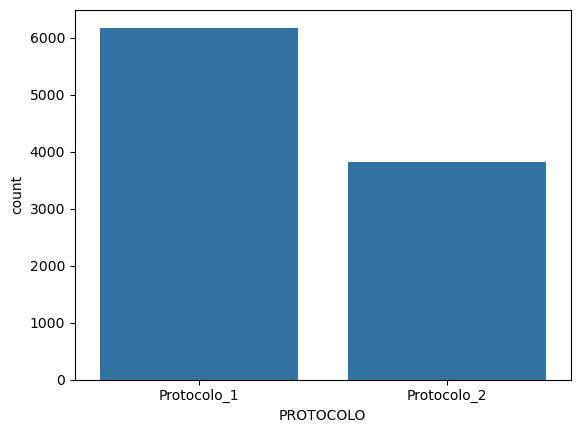

In [302]:
temp = df['PROTOCOLO'].value_counts()
sns.barplot(temp)

El problema no presenta un desbalanceo de clases. Por ende, se puede realizar un algoritmo de arboles de decisión binaria (XGBoost)

In [304]:
df.describe()

,ID_PAQUETE,ALTO,ANCHO,LARGO,PESO_ASIGNADO
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,27.643963,26.565353,30.660802,16.150526
std,2886.89568,20.452474,14.963486,17.270266,18.991541
min,1.00000,6.940000,5.380000,12.270000,0.100000
25%,2500.75000,12.340000,14.670000,17.340000,4.483091
50%,5000.50000,14.465000,18.900000,19.420000,8.677757
75%,7500.25000,37.720000,35.460000,40.980000,20.873973
max,10000.00000,117.550000,76.330000,87.190000,100.000000


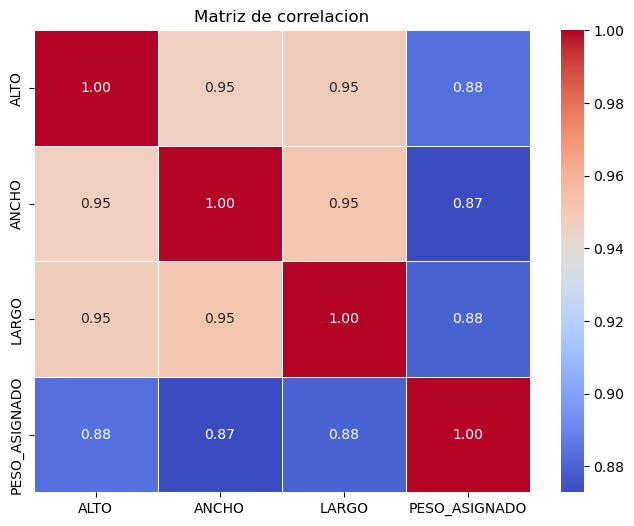

In [306]:
corr_mat = df[['ALTO', 'ANCHO','LARGO','PESO_ASIGNADO']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', linewidth=.5)
plt.title('Matriz de correlacion')
plt.show()

<Axes: xlabel='CATEGORIA_ASIGNADA', ylabel='count'>

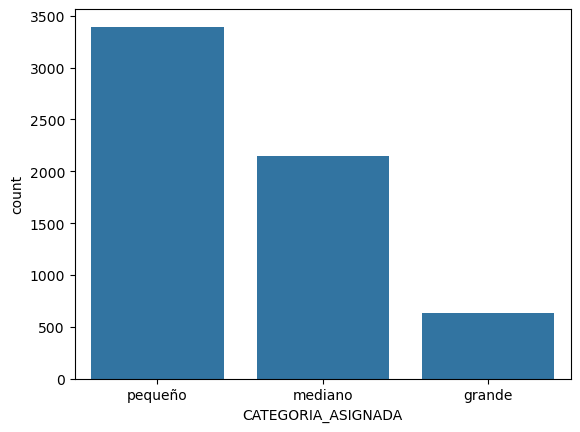

In [308]:
df_temp = df[df['PROTOCOLO'] == 'Protocolo_1']
temp = df_temp['CATEGORIA_ASIGNADA'].value_counts()
sns.barplot(temp)

<Axes: xlabel='CATEGORIA_ASIGNADA', ylabel='count'>

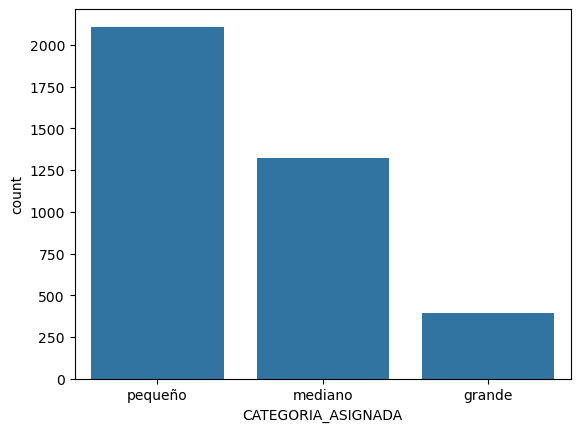

In [310]:
df_temp = df[df['PROTOCOLO'] == 'Protocolo_2']
temp = df_temp['CATEGORIA_ASIGNADA'].value_counts()
sns.barplot(temp)

XGBoost es un modelo que no acepta valores tipo string, por ende, convertiré algunas variables categóricas a (1,0), tales como el tipo de manipulación, temperatura de almacenamiento y para el lugar de procedencia utilizaré WoE (Weight of Evidence), que es una técnica utilizada que convierte las variables categóricas en números basados en las probabilidades por evento.

In [339]:
df = woe_procedencia(df)
#Tipo de manipulacion
df['TIPO_MANIPULACION_NUM'] = df['TIPO_MANIPULACION'].map({'normal': 1, 'fragil': 0})
#Temperatura
df['TEMPERATURA_ALMACENAMIENTO_NUM'] = df['TEMPERATURA_ALMACENAMIENTO'].map({'ambiente': 1, 'refrigerado': 0})
#Tipo de manipulacion
df['TIPO_MANIPULACION_NUM'] = df['TIPO_MANIPULACION'].map({'normal': 1, 'fragil': 0})
#Protocolo
df['PROTOCOLO_TARGET'] = df['PROTOCOLO'].map({'Protocolo_1': 1, 'Protocolo_2': 0})

In [341]:
df_1.head(5)

,ID_PAQUETE,CATEGORIA_ASIGNADA,ALTO,ANCHO,LARGO,PESO_ASIGNADO,TIPO_MANIPULACION,LUGAR_PROCEDENCIA,TEMPERATURA_ALMACENAMIENTO,PROTOCOLO,LUGAR_PROCEDENCIA_WOE,TIPO_MANIPULACION_NUM,TEMPERATURA_ALMACENAMIENTO_NUM,PROTOCOLO_TARGET
0,1,pequeño,11.25,16.58,17.13,8.096204,normal,B,ambiente,Protocolo_2,0.049232,1,1,0
1,2,mediano,36.87,33.50,41.15,24.975459,fragil,D,ambiente,Protocolo_2,-0.009582,0,1,0
2,3,pequeño,11.99,14.11,15.45,4.946614,normal,A,refrigerado,Protocolo_1,-0.075119,1,0,1
3,4,pequeño,11.79,16.20,18.42,9.365610,normal,C,ambiente,Protocolo_2,0.040459,1,1,0
4,5,pequeño,12.47,13.49,17.03,7.179166,normal,B,refrigerado,Protocolo_1,0.049232,1,0,1


Ahora, la incorporación del modelo

In [361]:
X = df[['ALTO', 'ANCHO', 'LARGO', 'PESO_ASIGNADO', 'TEMPERATURA_ALMACENAMIENTO_NUM', 'LUGAR_PROCEDENCIA_WOE', 'TIPO_MANIPULACION_NUM']]
y = df['PROTOCOLO_TARGET']

X = X.values
y = y.values

In [389]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [391]:
model = xgb.XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train)

In [395]:
y_pred = model.predict(X_test)

In [397]:
accuracy = accuracy_score(y_test, y_pred)

In [405]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}\n')
class_report = classification_report(y_test, y_pred)
print(f'Classification report \n{class_report}')

Accuracy: 0.5585

Classification report 
              precision    recall  f1-score   support

           0       0.38      0.20      0.26       787
           1       0.60      0.79      0.68      1213

    accuracy                           0.56      2000
   macro avg       0.49      0.50      0.47      2000
weighted avg       0.52      0.56      0.52      2000



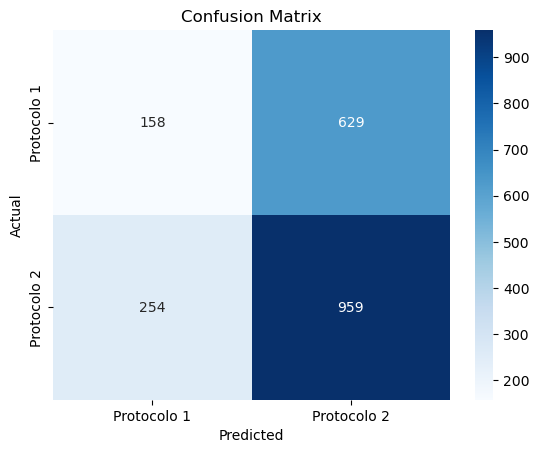

In [421]:
#Matriz de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Protocolo 1", "Protocolo 2"], yticklabels=["Protocolo 1", "Protocolo 2"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [411]:
import shap

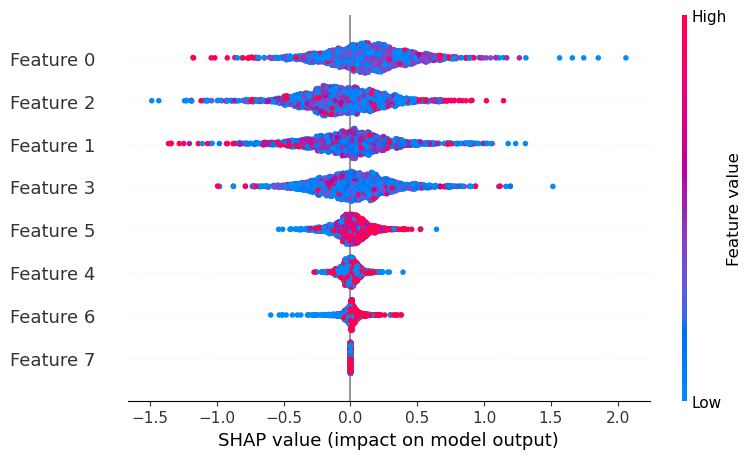

In [417]:
#Primero se generea el arbol explicativo
explainer = shap.TreeExplainer(model)

#Se toma el set de prueba
shap_values = explainer.shap_values(X_test)

#Se genera la prueba
shap.summary_plot(shap_values, X_test)

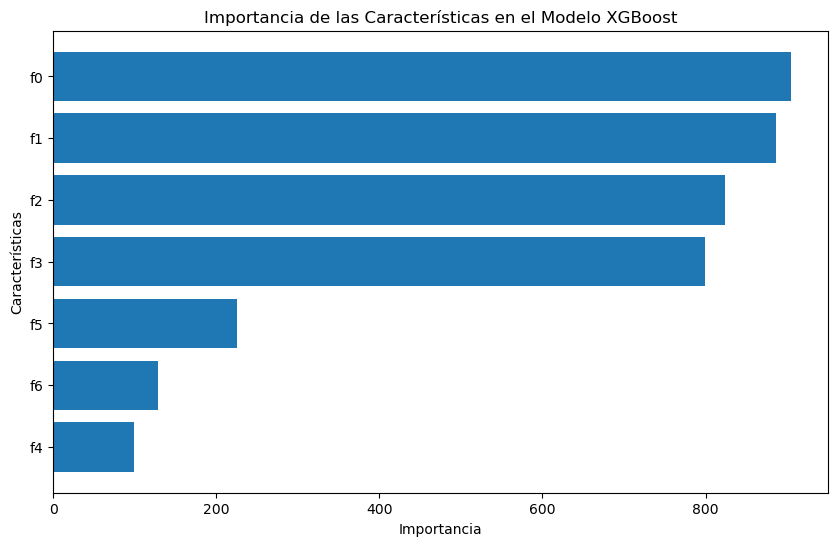

In [415]:
feature_importance = model.get_booster().get_score(importance_type='weight')

# Convertir a DataFrame para facilitar la visualización
feature_importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
})

# Ordenar por la importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

top_ten = feature_importance_df.head(10)

# Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(top_ten['Feature'], top_ten['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características en el Modelo XGBoost')
plt.show()

## Ejercicio 4

Utilizando IBM Cloud, implementa, en la nube, el modelo elaborado en el inciso anterior y realiza las configuraciones adecuadas para que este pueda consultarse desde cualquier dispositivo remoto que cumpla con los requisitos de seguridad de la plataforma.

Primero guardaré el modelo y los datos utilizados en esta fase, con el fin de exportarlo de manera correcta.

In [434]:
model.save_model('Fase2_ML - Model.json')

In [5]:
df.to_csv('Fase2_ML - Data.csv')

NameError: name 'df' is not defined

Para mayor informacion sobre la incorporación de este punto, acudir a *../notebooks/Fase2_ML - IBM_Model_Inc.ipynb*

## Ejercicio 5

Considerando: 
    
    a. La planta industrial tiene una distribucion como la que se muestra a continuación:

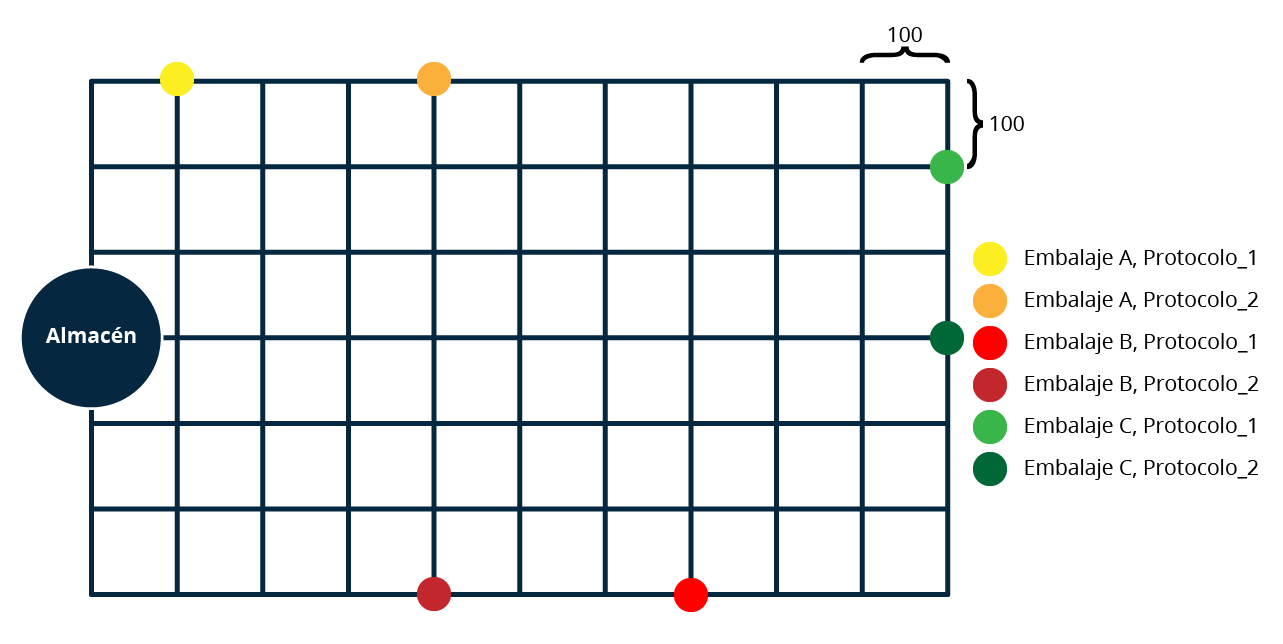

    b. Cada vehículo puede transportar un máximo de tres productos al mismo tiempo
    c. Los productos en el almacen no poseen un orden determinado
    d. Un vehículo puede seleccionar cualquier producto con la misma probabilidad

Elabora un programa que sea capaz de determinar la ruta óptima que debe tomar el vehículo para distribuir los productos por la planta industrial, garantizando que:

    a. Nunca se repita 2 veces el mismo destino en cada viaje
    b. Los productos del protocolo_1 tengan prioridad
    c. La ruta trazada sea siempre la menor
    

Podemos representar el mapa presentado anteriormente como una matriz de la siguiente manera:

$$
\text{Planta} =
\begin{bmatrix}
0 & \text{Embalaje\_A\_Protocolo\_1} & 0 & 0 & \text{Embalaje\_A\_Protocolo\_2} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \text{Embalaje\_C\_Protocolo\_2} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\text{Almacen} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \text{Embalaje\_C\_Protocolo\_2} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & \text{Embalaje\_B\_Protocolo\_2} & 0 & 0 & \text{Embalaje\_B\_Protocolo\_1} & 0 & 0 & 0
\end{bmatrix}$$

Una vez representada la matriz, se presenta un modelo de optimización de grafos, es decir, el *Algoritmo de Dijkstra*, con el fin de encontrar el camino más corto entre 2 puntos.

**Algoritmo de Dijkstra**

Cuando se trabaja con grafos dirigidos etiquetados o ponderados con factores de peso no negativos, es frecuente buscar el camino más corto entre dos vértices dados; es decir, el camino que nos permita llegar desde un vértice origen a un vértice destino recorriendo la menor distancia o con el menor costo.

Los algoritmos más usados para este fin son: Dijkstra, Floyd y Warshall.  

Los tres algoritmos utilizan una matriz de adyacencia ponderada o etiquetada: que es la misma matriz de adyacencia utilizada para representar grafos, pero con la diferencia que en lugar de colocar un número “1” cuando dos vértices son adyacentes, se coloca el peso o ponderación asignado a la arista que los une.  

Con frecuencia en la matriz etiquetada suele utilizarse la siguiente notación: 

Suponiendo que $M [i, j]$ representa la matriz de adyacencia, tenemos: 

$$M [i, j] = 0 \text{, si } i = j$$ 
$$M [i, j] = 1000 \text{ ó } \infty \text{, si no existe un camino de } i \text{ a } j \text{, donde } i \neq j$$ 
$$M [i, j] = \text{ costo de ir del vértice } i \text{ al vértice } j$$

Otro nombre con el cual suele llamarse a una matriz de adyacencia etiquetada es matriz de distancias o matriz de costos. 

El problema de buscar un camino más corto entre dos nodos dados se puede resolver mediante un algoritmo voraz conocido como *Algoritmo de Dijkstra.*

El algoritmo cuenta con los siguientes pasos:

1. Seleccionar vértice de partida, es decir un origen.
2. Marcar el punto de partida como el punto de inicio.
3. Determinar los caminos especiales desde el nodo de partida, es decir, el de inicio.
4. Camino especial es aquel que solo puede trazarse a través de los nodos o vértices ya marcados.
5. Para cada nodo no marcado, se debe determinar si es mejor usar el camino especial antes calculado o si es mejor usar el nuevo camino especial que resulte al marcar este nuevo nodo.
6. Para seleccionar un nuevo nodo no marcado como referencia, deberá tomarse aquel cuyo camino especial para llegar a él es el mínimo, por ejemplo si anteriormente marqué el nodo o vértice 2, el cual tiene dos nodos adyacentes 3 y 4 cuyo peso en la arista corresponde a 10 y 5 respectivamente, se tomará como nuevo nodo de partida el 4, ya que el peso de la arista o camino es menor.
7. Cada camino mínimo corresponde a la suma de los pesos de las aristas que forman el camino para ir del nodo principal al resto de nodos, pasando únicamente por caminos especiales, es decir nodos marcados. 

In [489]:
mapa_planta = [
    [0, 'Embalaje_A_Protocolo_1', 0, 0, 'Embalaje_A_Protocolo_2', 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'Embalaje_C_Protocolo_1'],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ['Almacen', 0, 0, 0, 0, 0, 0, 0, 0, 0, 'Embalaje_C_Protocolo_2'],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 'Embalaje_B_Protocolo_2', 0, 0, 'Embalaje_B_Protocolo_1', 0, 0, 0]
]

# Dimensiones de la planta
filas = len(mapa_planta)
cols = len(mapa_planta[0])

# Movimientos posibles (arriba, abajo, izquierda, derecha)
movs = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Movimientos hacia arriba, abajo, izquierda, derecha

# Ejecutar la función de distribución
distribuir_productos(mapa_planta)

Ruta para entregar Embalaje_A_Protocolo_1: [(3, 0), (2, 0), (1, 0), (0, 0), (0, 1)]
Ruta para entregar Embalaje_B_Protocolo_1: [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 7), (5, 7), (6, 7)]
Ruta para entregar Embalaje_C_Protocolo_1: [(3, 0), (2, 0), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)]
Ruta para entregar Embalaje_A_Protocolo_2: [(3, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Ruta para entregar Embalaje_B_Protocolo_2: [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 4), (5, 4), (6, 4)]
Ruta para entregar Embalaje_C_Protocolo_2: [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10)]
